# Project 2 - Supervised Learning

### Let's first check the data in the **train.csv**

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
import time

train_data = pd.read_csv('train.csv')

# Remove oversampling
claimed = train_data[train_data['is_claim'] == 1]
not_claimed = train_data[train_data['is_claim'] == 0]
sample_size = min(len(claimed), len(not_claimed))
train_data = pd.concat([claimed.sample(n=sample_size), not_claimed.sample(n=sample_size)])

print(train_data.head())

      policy_id  policy_tenure  age_of_car  age_of_policyholder area_cluster   
36895   ID36896       1.166285        0.11             0.403846           C8  \
53939   ID53940       1.240149        0.02             0.355769           C8   
18680   ID18681       0.583181        0.00             0.769231           C8   
24958   ID24959       0.064401        0.10             0.596154           C2   
26119   ID26120       0.479604        0.07             0.326923           C6   

       population_density  make segment model fuel_type  ... is_brake_assist   
36895                8794     3      C2    M4    Diesel  ...             Yes  \
53939                8794     3      C2    M4    Diesel  ...             Yes   
18680                8794     1      B2    M6    Petrol  ...             Yes   
24958               27003     3      C2    M4    Diesel  ...             Yes   
26119               13051     2       A    M3    Petrol  ...              No   

      is_power_door_locks is_central_l

We had to have the same number of claims and not claims to avoid **oversampling**

### Let's check if there are columns with missing values
### And change the non-numeric columns to numeric

In [20]:
cols_with_na = train_data.columns[train_data.isna().any()].tolist()
print('Columns with missing values:', cols_with_na)

train_data['policy_id'] = train_data['policy_id'].apply(lambda x: x.replace('ID', ''))
train_data['area_cluster'] = train_data['area_cluster'].apply(lambda x: x.replace('C', ''))
train_data = pd.get_dummies(train_data, columns=['segment', 'fuel_type', 'engine_type', 'rear_brakes_type', 'steering_type'])
train_data['model'] = train_data['model'].apply(lambda x: x.replace('M', ''))
train_data = train_data.replace({"Yes": True, "No": False})
encoder = LabelEncoder()
train_data['transmission_type'] = encoder.fit_transform(train_data['transmission_type'])

train_data['max_torque'] = train_data['max_torque'].apply(lambda s: float(s.split('Nm@')[0]) * float(s.split('Nm@')[1].replace('rpm', '')))
train_data['max_power'] = train_data['max_power'].apply(lambda s: float(s.split('bhp@')[0]) * float(s.split('bhp@')[1].replace('rpm', '')))


Columns with missing values: []


As we can see, there are no missing values in our data set

### Let's now get some more general information of our features

In [21]:
print(train_data.describe())

       policy_tenure   age_of_car  age_of_policyholder  population_density   
count    7496.000000  7496.000000          7496.000000         7496.000000  \
mean        0.665598     0.066826             0.473151        18124.893276   
std         0.407349     0.054818             0.124837        16925.507386   
min         0.002801     0.000000             0.288462          290.000000   
25%         0.272972     0.020000             0.375000         6112.000000   
50%         0.679824     0.060000             0.461538         8794.000000   
75%         1.062395     0.110000             0.548077        27003.000000   
max         1.386520     0.420000             0.951923        73430.000000   

              make     max_torque      max_power      airbags  displacement   
count  7496.000000    7496.000000    7496.000000  7496.000000   7496.000000  \
mean      1.761873  444872.549360  403494.844450     3.135806   1167.026014   
std       1.139148  181037.909914  115799.867806     1.83639

In [ ]:
%matplotlib inline

sb.pairplot(train_data)

After some investigating, there are no major outliers that require work.
There are some variables that seem to have no correlation with the `is_claim` feature

### Now let's check what features have no correlation with the test feature

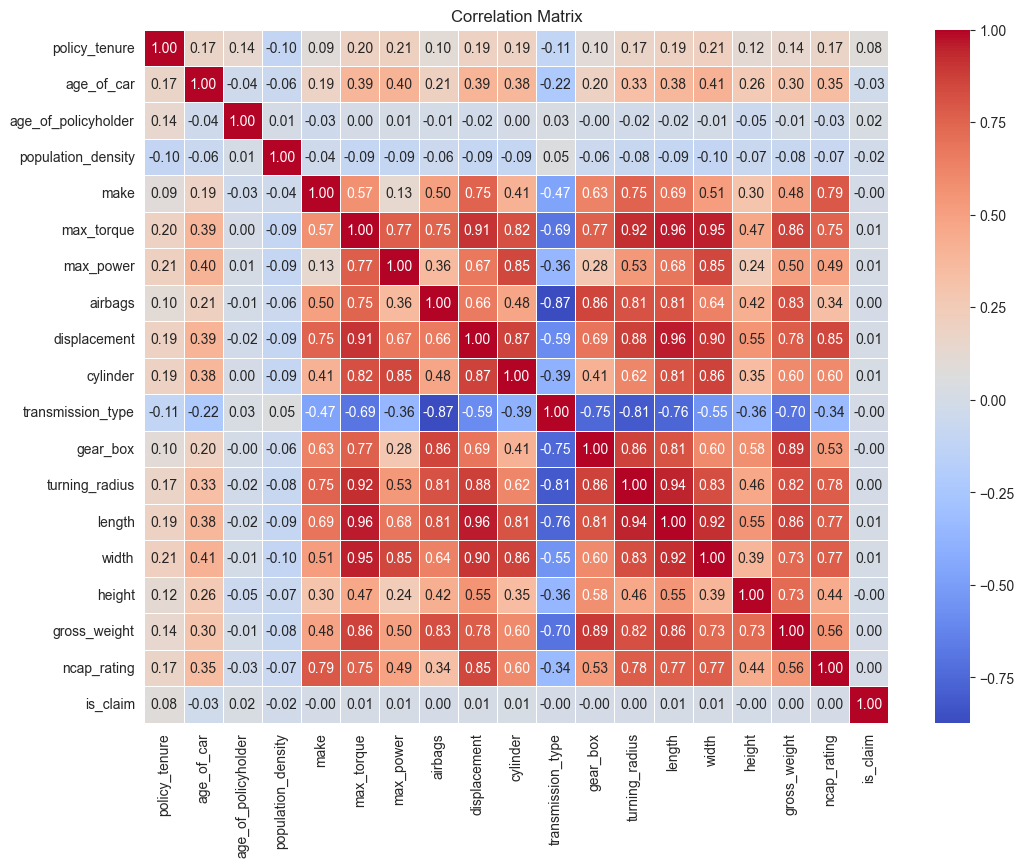

In [4]:

numeric_columns = train_data.select_dtypes(include='number')
train_data_numeric = train_data[numeric_columns.columns]

correlation_matrix = train_data_numeric.corr()

# Creating the subsets without the highly correlated features
corr_cols08 = set()
corr_cols09 = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if correlation_matrix.columns[i] != correlation_matrix.columns[j] and abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[j]
            corr_cols08.add(colname)

        if correlation_matrix.columns[i] != correlation_matrix.columns[j] and abs(correlation_matrix.iloc[i, j]) > 0.9:
            colname = correlation_matrix.columns[j]
            corr_cols09.add(colname)


train_data_08 = train_data_numeric.drop(columns=corr_cols08)
train_data_09 = train_data_numeric.drop(columns=corr_cols09)

plt.figure(figsize=(12, 9))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
non_numeric_columns = train_data.select_dtypes(exclude='number')

for column in non_numeric_columns:
    if 'id' in column: continue
    crosstab_table = pd.crosstab(train_data[column], train_data['is_claim'])
    crosstab_table.plot(kind='bar', stacked=True)

    plt.title(f'Crosstab for {column}')
    plt.xlabel(column)
    plt.ylabel('Count')

    plt.show()



Numeric features don't correlate with the `is_claim` feature, most probably because it is a binary feature and not a number one.
But there are others features that correlate with each other, which might give more strength to those values, something that we want to avoid.
A good way of avoiding it is to remove the column that correlate too much with another (>= 0.85)

In non-numeric features we didn't get a clear separation but there are some choices that are more favorable. For example in the feature `segment`, people insure more an `A` than a `Utility` value

### Let's now dive into the classifier methods

We have done an initial comparison of all the algorithms

In [ ]:
classifiers = {
    'Decision Tree': DecisionTreeClassifier(),
    'Neural Network': MLPClassifier(),
    'K-NN': KNeighborsClassifier(),
    'SVM': SVC()
}
target_column = "is_claim"
X = train_data.drop(target_column, axis=1)
y = train_data[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Train and evaluate the classifiers
results = []

for (name, classifier) in classifiers.items():

    print((name, classifier))
    # Train the model
    start_time = time.time()
    classifier.fit(X_train, y_train)
    train_time = time.time() - start_time

    # Test the model
    start_time = time.time()
    y_pred = classifier.predict(X_test)
    test_time = time.time() - start_time

    # Calculate evaluation metrics
    conf_matrix = confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Store the results
    results.append({
        'Classifier': name,
        'Confusion Matrix': conf_matrix,
        'Precision': precision,
        'Recall': recall,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Train Time': train_time,
        'Test Time': test_time
    })
# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

# Visualize the results (e.g., using Seaborn or Matplotlib)
# Example: Plotting the accuracy of different classifiers
sb.barplot(x='Classifier', y='Accuracy', data=results_df)
plt.show()

Numeric features don't correlate with the `is_claim` feature, most probably because it is a binary feature and not a number one.
But there are others features that correlate with each other, which might give more strength to those values, something that we want to avoid.
A good way of avoiding it is to remove the column that correlate too much with another (>= 0.85)

In non-numeric features we didn't get a clear separation but there are some choices that are more favorable. For example in the feature `segment`, people insure more an `A` than a `Utility` value

### Let's now dive into the classifier methods

We have done an initial comparison of all the algorithms

In [24]:
classifiers = {
    'Decision Tree': DecisionTreeClassifier(),
    'Neural Network': MLPClassifier(),
    'K-NN': KNeighborsClassifier(),
    'SVM': SVC()
}
target_column = "is_claim"
X = train_data.drop(target_column, axis=1)
y = train_data[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
        Classifier          Confusion Matrix  Precision    Recall  Accuracy   
0    Decision Tree  [[581, 537], [510, 621]]   0.534415  0.534460  0.534460  \
1    Decision Tree  [[574, 544], [524, 607]]   0.525081  0.525122  0.525122   
2    Decision Tree  [[585, 533], [511, 620]]   0.535755  0.535794  0.535794   
3    Decision Tree  [[591, 527], [526, 605]]   0.531790  0.531792  0.531792   
4    Decision Tree  [[588, 530], [511, 620]]   0.537093  0.537128  0.537128   
5   Neural Network    [[1118, 0], [1131, 0]]   0.750008  0.497110  0.497110   
6   Neural Network  [[543, 575], [500, 631]]   0.521923  0.522010  0.522010   
7   Neural Network  [[25, 1093], [24, 1107]]   0.506673  0.503335  0.503335   
8   Neural Network  [[777, 341], [792, 339]]   0.496884  0.496221  0.496221   
9   Neural Network  [[16, 1102], [14, 1117]]   0.518270  0.503779  0.503779   
10            K-NN  [[589, 529], [581, 550]]   0.506593  0.506447  0.506447   
11          

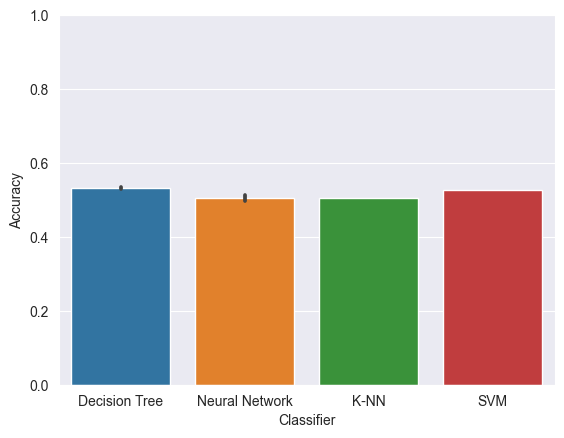

In [27]:
# Train and evaluate the classifiers
results = []

for (name, classifier) in classifiers.items():

    for _ in range(5):
        print(_)
        # Train the model
        start_time = time.time()
        classifier.fit(X_train, y_train)
        train_time = time.time() - start_time

        # Test the model
        start_time = time.time()
        y_pred = classifier.predict(X_test)
        test_time = time.time() - start_time

        # Calculate evaluation metrics
        conf_matrix = confusion_matrix(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
        recall = recall_score(y_test, y_pred, average='weighted')
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Store the results
        results.append({
            'Classifier': name,
            'Confusion Matrix': conf_matrix,
            'Precision': precision,
            'Recall': recall,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'Train Time': train_time,
            'Test Time': test_time
        })
# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

plt.ylim(0, 1)
sb.barplot(x='Classifier', y='Accuracy', data=results_df)
plt.show()

### Neural Network

0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
                   Set             Confusion Matrix  Precision    Recall   
0          Default Set     [[26, 1091], [27, 1105]]   0.496919  0.502890  \
1          Default Set       [[1118, 0], [1131, 0]]   0.750008  0.497110   
2          Default Set       [[1144, 0], [1105, 0]]   0.750075  0.508671   
3          Default Set     [[249, 908], [239, 853]]   0.497689  0.489996   
4          Default Set     [[1081, 42], [1087, 39]]   0.490037  0.497999   
5   >= 0.9 correlation      [[16459, 0], [1119, 0]]   0.940393  0.936341   
6   >= 0.9 correlation      [[16453, 0], [1125, 0]]   0.940096  0.936000   
7   >= 0.9 correlation      [[16412, 0], [1166, 0]]   0.938067  0.933667   
8   >= 0.9 correlation     [[23, 16431], [1, 1123]]   0.901145  0.065195   
9   >= 0.9 correlation      [[16506, 0], [1072, 0]]   0.942734  0.939015   
10  >= 0.8 correlation  [[3750, 12678], [232, 918]]   0.884544  0.265559   
11  >= 0.8 correlation      [[16473, 0], [1105, 0]]   0.94

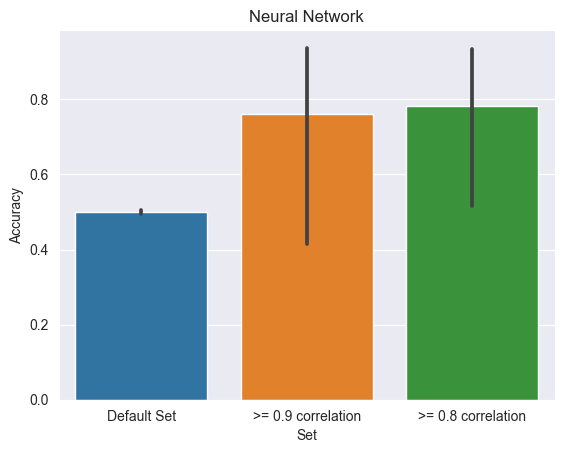

In [22]:
sets = {
    'Default Set': train_data,
    '>= 0.9 correlation': train_data_09,
    '>= 0.8 correlation': train_data_08,
}

results = []

for (name, data_set) in sets.items():
     # Train the model
     for _ in range(5): #running 5 times each
         print(_)
         neural_network = MLPClassifier()
         target_column = "is_claim"
         X = data_set.drop(target_column, axis=1)
         y = data_set[target_column]
         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
         start_time = time.time()

         neural_network.fit(X_train, y_train)
         train_time = time.time() - start_time

         # Test the model
         start_time = time.time()
         y_pred = neural_network.predict(X_test)
         test_time = time.time() - start_time

         # Calculate evaluation metrics
         conf_matrix = confusion_matrix(y_test, y_pred)
         precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
         recall = recall_score(y_test, y_pred, average='weighted')
         accuracy = accuracy_score(y_test, y_pred)
         f1 = f1_score(y_test, y_pred, average='weighted')

         # Store the results
         results.append({
            'Set' : name,
            'Confusion Matrix': conf_matrix,
            'Precision': precision,
            'Recall': recall,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'Train Time': train_time,
            'Test Time': test_time
         })
# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

plt.title("Neural Network")
sb.barplot(x='Set', y='Accuracy', data=results_df)
plt.show()